## Reproducing Paper _Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks_ : Benchmarking Results

This notebook replicates experiments from the paper [_Programmable Bootstrapping Enables Efficient Homomorphic Inference of Deep Neural Networks_](https://pypi.org/project/concrete-ml/
), published in 2019. 
It provides an in-depth analysis of the deep neural network architectures NN-20 and NN-50, along with their training processes using floating point precisio and their [quantization](https://docs.zama.ai/concrete-ml/explanations/quantization) using the Quantization Aware Training (QAT) and Post Training Quantization (PTQ) methods. 

We compare the original paper's findings with the results from the latest version of [Concrete ML](https://whitepaper.zama.ai/). This comparison highlight the significant advancements made by Concrete ML, particularly in execution speed while preserving model accuracy.

In [1]:
import csv
import os
import pickle as pkl
import random
import sys
import time
import warnings
from collections import OrderedDict
from glob import glob
from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import brevitas
import brevitas.nn as qnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from brevitas import config
from concrete.fhe.compilation import Configuration
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

from concrete import fhe
from concrete.ml.torch.compile import compile_brevitas_qat_model, compile_torch_model

warnings.filterwarnings("ignore", category=UserWarning)

## Architecture

All networks begin with a convolutional layer configured with `in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'`. At the time of writing this notebook, `padding=1` is not yet supported; as a workaround, padding is added during the data loading transformation process. 

This is followed by 20 linear layers of 92 neurones with ReLU activation for NN-20, and 50 layers for NN-50.

In [2]:
device = "cpu"

# Input size
INPUT_IMG_SIZE = 28

BATCH_SIZE = 64

# MNIST data normalization
MEAN = STD = 0.5

SEED = 42

In [3]:
FEATURES_MAPS = [
    # The Bravitas.QuantIdentiy layer, only used in the quant NN, aims to quantize the input.
    # ("I",),
    # Convolution layer, with:
    #  in_channel=1, out_channels=1, kernel_size=3, stride=1, padding_mode='replicate'
    ("C", 1, 1, 3, 1, "replicate"),
]

# The article presents 3 neural network depths. In this notebook, we focus NN-20 and NN-50
# architectures. The parameter `nb_layers`: controls the depth of the NN.
LINEAR_LAYERS = lambda nb_layers, output_size: (
    [
        ("R",),
        ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),
        ("B", 92),
    ]
    + [
        ("R",),
        ("L", 92, 92),
        ("B", 92),
    ]
    * (nb_layers - 2)
    + [("L", 92, output_size)]
)

### FP32 MNIST Neural Nerwork 

In [4]:
class Fp32MNIST(torch.nn.Module):
    """MNIST Torch model."""

    def __init__(self, nb_layers: int, output_size: int = 10):
        super(Fp32MNIST, self).__init__()
        """MNIST Torch model.

        Args:
            nb_layers (int): Number of layers.
            output_size (int): Number of classes.
        """
        self.nb_layers = nb_layers
        self.output_size = output_size

        def make_layers(t):
            if t[0] == "C":
                return torch.nn.Conv2d(
                    in_channels=t[1],
                    out_channels=t[2],
                    kernel_size=t[3],
                    stride=t[4],
                    padding_mode=t[5],
                )
            if t[0] == "L":
                return torch.nn.Linear(in_features=t[1], out_features=t[2])
            if t[0] == "R":
                return torch.nn.ReLU()
            if t[0]:
                return torch.nn.BatchNorm1d(t[1])

            raise NameError(f"'{t}' not defined")

        # QuantIdentity layers are ignored in the floationg point architecture.
        self.features_maps = torch.nn.Sequential(
            *[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"]
        )
        self.linears = torch.nn.Sequential(
            *[
                make_layers(t)
                for t in LINEAR_LAYERS(self.nb_layers, self.output_size)
                if t[0] != "I"
            ]
        )

    def forward(self, x):
        x = self.features_maps(x)
        x = torch.nn.Flatten()(x)
        x = self.linears(x)
        return x

### Quantized MNIST Neural Network

In [5]:
class QuantMNIST(torch.nn.Module):
    """Quantized MNIST network with Brevitas."""

    def __init__(
        self,
        n_bits: int,
        nb_layers: int,
        output_size: int = 10,
        act_quant: brevitas.quant = brevitas.quant.Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = brevitas.quant.Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            n_bits (int): Precision bit of quantization.
            nb_layers (int): Number of layers.
            output_size (int): Number of classes
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.
        """
        super(QuantMNIST, self).__init__()

        self.n_bits = n_bits
        self.nb_layers = nb_layers
        self.output_size = output_size

        def tuple2quantlayer(t):
            if t[0] == "R":
                return qnn.QuantReLU(
                    return_quant_tensor=True, bit_width=n_bits, act_quant=act_quant
                )
            if t[0] == "C":
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=n_bits,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else n_bits
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )
            if t[0] == "B":
                return torch.nn.BatchNorm1d(t[1])

        self.features_maps = torch.nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0]]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=n_bits, act_quant=act_quant, return_quant_tensor=True
        )
        self.identity2 = qnn.QuantIdentity(
            bit_width=n_bits, act_quant=act_quant, return_quant_tensor=True
        )

        # QuantIdentity layers are taken into account
        self.linears = torch.nn.Sequential(
            *[tuple2quantlayer(t) for t in LINEAR_LAYERS(self.nb_layers, self.output_size)]
        )

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        x = torch.flatten(x, 1)
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

## Some useful functions

In [6]:
def plot_dataset(data_loader: DataLoader, n: int = 10) -> None:
    """Visualize some images from a given data loader.

    Args:
        data_loader (DataLoader): Data loader.
        n (int): Limit the number of images to display to `n`.
    """

    # Class names
    class_names = data_loader.dataset.classes

    _, ax = plt.subplots(figsize=(12, 6))

    images, labels = next(iter(data_loader))

    # Make a grid from batch and rotate to get a valid shape for imshow
    images = make_grid(images[:n], nrow=n).permute((1, 2, 0))
    # Remove the previous normalization
    images = images * np.array(STD) + np.array(MEAN)

    ax.imshow(images)

    ax.set_title("".join([f"{class_names[img]:<13}" for img in labels[:n]]))
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [7]:
def mapping_keys(pre_trained_weights: Dict, model: torch.nn.Module, device: str) -> torch.nn.Module:
    """
    Initialize the quantized model with pre-trained fp32 weights.

    Args:
        pre_trained_weights (Dict): The state_dict of the pre-trained fp32 model.
        model (nn.Module): The Brevitas model.
        device (str): Device type.

    Returns:
        Callable: The quantized model with the pre-trained state_dict.
    """

    # Brevitas requirement to ignore missing keys
    config.IGNORE_MISSING_KEYS = True

    old_keys = list(pre_trained_weights.keys())
    new_keys = list(model.state_dict().keys())
    new_state_dict = OrderedDict()

    for old_key, new_key in zip(old_keys, new_keys):
        new_state_dict[new_key] = pre_trained_weights[old_key]

    model.load_state_dict(new_state_dict)
    model = model.to(device)

    return model

In [8]:
def train(
    model: torch.nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    param: Dict,
    step: int = 1,
    device: str = "cpu",
) -> torch.nn.Module:
    """Training the model.

    Args:
        model (nn.Module): A PyTorch or Brevitas network.
        train_loader (DataLoader): The training set.
        test_loader (DataLoader): The test set.
        param (Dict): Set of hyper-parameters to use depending on whether
            CIFAR-10 or CIFAR-100 is used.
        step (int): Display the loss and accuracy every `epoch % step`.
        device (str): Device type.
    Returns:
        nn.Module: the trained model.
    """

    if param["seed"]:

        torch.manual_seed(param["seed"])
        random.seed(param["seed"])

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=param["lr"])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=param["milestones"], gamma=param["gamma"]
    )

    # Save the state_dict
    dir = Path(".") / param["dir"] / param["training"]
    dir.mkdir(parents=True, exist_ok=True)

    # To avoid breaking up the tqdm bar
    with tqdm(total=param["epochs"], file=sys.stdout) as pbar:

        for i in range(param["epochs"]):
            # Train the model
            model.train()
            loss_batch_train, accuracy_batch_train = [], []

            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                yhat = model(x)
                loss_train = param["criterion"](yhat, y)
                loss_train.backward()
                optimizer.step()

                loss_batch_train.append(loss_train.item())
                accuracy_batch_train.extend((yhat.argmax(1) == y).cpu().float().tolist())

            if scheduler:
                scheduler.step()

            param["accuracy_train"].append(np.mean(accuracy_batch_train))
            param["loss_train_history"].append(np.mean(loss_batch_train))

            # Evaluation during training:
            # Disable autograd engine (no backpropagation)
            # To reduce memory usage and to speed up computations
            with torch.no_grad():
                # Notify batchnormalization & dropout layers to work in eval mode
                model.eval()
                loss_batch_test, accuracy_batch_test = [], []
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    yhat = model(x)
                    loss_test = param["criterion"](yhat, y)
                    loss_batch_test.append(loss_test.item())
                    accuracy_batch_test.extend((yhat.argmax(1) == y).cpu().float().tolist())

                param["accuracy_test"].append(np.mean(accuracy_batch_test))
                param["loss_test_history"].append(np.mean(loss_batch_test))

            if i % step == 0:
                pbar.write(
                    f"Epoch {i:2}: Train loss = {param['loss_train_history'][-1]:.4f} "
                    f"VS Test loss = {param['loss_test_history'][-1]:.4f} - "
                    f"Accuracy train: {param['accuracy_train'][-1]:.4f} "
                    f"VS Accuracy test: {param['accuracy_test'][-1]:.4f}"
                )
                pbar.update(step)

            torch.save(
                model.state_dict(),
                f"{dir}/{param['dataset_name']}_{param['training']}_state_dict.pt",
            )

    print("Save in:", f"{dir}/{param['dataset_name']}_{param['training']}_state_dict.pt")

    torch.save(
        model.state_dict(), f"{dir}/{param['dataset_name']}_{param['training']}_state_dict.pt"
    )
    import pickle as pkl

    with open(f"{dir}/{param['dataset_name']}_history.pkl", "wb") as f:
        pkl.dump(param, f)

    torch.cuda.empty_cache()

    return model

In [9]:
def torch_inference(
    model: torch.nn.Module,
    data: DataLoader,
    device: str = "cpu",
    verbose: bool = False,
) -> float:
    """Returns the `top_k` accuracy.

    Args:
        model (ntorch.n.Module): A PyTorch or Brevitas network.
        data (DataLoader): The test or evaluation set.
        device (str): Device type.
        verbose (bool): For display.
    Returns:
        float: The top_k accuracy.
    """
    correct = []
    total_example = 0
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        for x, y in tqdm(data, disable=verbose is False):
            x, y = x.to(device), y
            yhat = model(x).cpu().detach()
            correct.append(yhat.argmax(1) == y)
            total_example += len(x)

    return np.mean(np.vstack(correct), dtype="float64")

In [10]:
def run_benchmark(
    model: Callable,
    compile_type: str,
    data_calibration,
    data_loader,
    ptq_bits: int = None,
):

    if compile_type == "qat":
        assert hasattr(model, "n_bits"), "The model must be a Brevitas neural network."
        bits = model.n_bits
        compile_n_bits = None
        nb_layers = model.nb_layers
        compile_function = compile_brevitas_qat_model
    else:
        assert not hasattr(model, "n_bits"), "The model must be a Torch neural network."
        bits = compile_n_bits = ptq_bits
        nb_layers = model.nb_layers
        compile_function = compile_torch_model

    history = []
    filename = f"history_{nb_layers=}_v2.csv"
    headers = [
        "Compile_type",
        "Number_of_layers",
        "Bits",
        "threshold",
        "max_bits",
        "Mean_FP32_accuracy",
        "Mean_disable_accuracy",
        "Mean_simulate_accuracy",
        "FHE_timing",
    ]

    thresholds = [
        {"n_bits": 5, "method": fhe.Exactness.APPROXIMATE},
        {"n_bits": 5, "method": "EXACT"},
        {"n_bits": 6, "method": "APPROXIMATE"},
        {"n_bits": 6, "method": "EXACT"},
        {"n_bits": 7, "method": "APPROXIMATE"},
        {"n_bits": 7, "method": "EXACT"},
    ]

    if not os.path.isfile(filename):
        with open(filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(headers)

    with open(filename, "a", newline="") as file:
        writer = csv.writer(file)

        for j, threshold in tqdm(enumerate(thresholds)):

            fhe_timing = -1
            history_fp32_predictions = []
            history_disable_predictions = []
            history_simulat_predictions = []

            print(threshold)
            if 1:
                q_module = compile_function(
                    model.to("cpu"),
                    torch_inputset=data_calibration,
                    n_bits=compile_n_bits,
                    rounding_threshold_bits=threshold,
                )

                max_bits = q_module.fhe_circuit.graph.maximum_integer_bit_width()
                print(f"{j=}: {max_bits=} after compilation")

                for i, (data, labels) in tqdm(enumerate(data_loader)):

                    fp32_predictions = model(data).cpu().detach()
                    history_fp32_predictions.extend(fp32_predictions.argmax(1) == labels)

                    data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

                    disable_predictions = q_module.forward(data, fhe="disable")
                    history_disable_predictions.extend(disable_predictions.argmax(1) == labels)

                    simulat_predictions = q_module.forward(data, fhe="simulate")
                    history_simulat_predictions.extend(simulat_predictions.argmax(1) == labels)

                    if i == 0:
                        start_time = time.time()
                        q_module.forward(data[0, None], fhe="execute")
                        fhe_timing = (time.time() - start_time) / 60.0

                row = [
                    compile_type,
                    nb_layers,
                    bits,
                    threshold,
                    max_bits,
                    np.mean(history_fp32_predictions),
                    np.mean(history_disable_predictions),
                    np.mean(history_simulat_predictions),
                    fhe_timing,
                ]

            else:
                row = [compile_type, nb_layers, bits, threshold, -1, -1, -1, -1, -1]

            writer.writerow(row)
            print(f"{j=}: {row=}")
            history.append(dict(zip(headers, row)))

    return history

## Load MNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


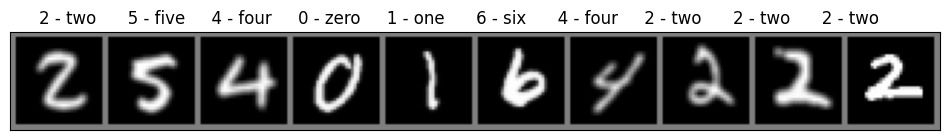

torch.Size([64, 1, 30, 30])

In [11]:
g = torch.Generator()
g.manual_seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

train_transform = transforms.Compose(
    [
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
        transforms.GaussianBlur(kernel_size=(3, 3)),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.Pad(1, padding_mode="edge"),
        transforms.ToTensor(),
        transforms.Normalize((MEAN,), (STD,)),
    ]
)

train_dataset = datasets.MNIST(download=True, root="./data", train=True, transform=train_transform)

test_dataset = datasets.MNIST(download=True, root="./data", train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    generator=g,
)

# The calibration data-set is used during the compilation step
# Where, the compiler requires an exhaustive set of data to evaluate the maximum integer bit-width
# within the graph.
data_calibration = next(iter(train_loader))[0]

plot_dataset(train_loader)

data_calibration.shape

Train the model

# FP32 MNIST 20

In [12]:
nb_layers, train_model = 20, False

param = {
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": f"./checkpoints/MNIST/NLP_{nb_layers}/",
}

fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(device)
checkpoint = torch.load(
    f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
)

if train_model:
    param["training"] = "fp32"
    param["epochs"] = 30
    param["lr"] = 0.01
    param["milestones"] = [15, 24]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)

else:
    checkpoint = torch.load(
        f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
    )
    fp32_mnist.load_state_dict(checkpoint)

acc_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_test = torch_inference(fp32_mnist, test_loader, device=device)

print(f"FP32 - with {fp32_mnist.nb_layers}-NN: {acc_train=:.3%} vs {acc_test=:.3%}")

FP32 - with 20-NN: acc_train=99.331% vs acc_test=98.137%


## Quant MNIST 20

In [35]:
bits, finetune_model, nb_layers = 4, False, 20

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to("cpu")
quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

print(f"Accuracy before fine-tuning: {acc_before_ft=:.3%}")

qmodel = compile_brevitas_qat_model(
    quant_mnist.to("cpu"),
    # Training
    torch_inputset=data_calibration,
    show_mlir=False,
    rounding_threshold_bits=6,
)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

if finetune_model:
    assert str(quant_mnist.nb_layers) in param["dir"]
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.1
    param["milestones"] = [1, 3]
    param["gamma"] = 0.1

    quant_mnist_20 = train(quant_mnist, train_loader, test_loader, param, device=device)

path = (
    f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
)

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to(device)
quant_mnist.load_state_dict(torch.load(path, map_location=device))

acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
acc_after_ft_test = torch_inference(quant_mnist, test_loader, device=device)

print(
    f"With {quant_mnist.n_bits}-bits and {quant_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
)
qmodel = compile_brevitas_qat_model(
    quant_mnist.to("cpu"),
    # Training
    torch_inputset=data_calibration,
    show_mlir=False,
    rounding_threshold_bits=6,
)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Accuracy before fine-tuning: acc_before_ft=9.746%
Maximum bit-width in the circuit: 13

With 4-bits and 20-nb_layers: acc_after_ft_train=97.287% vs acc_after_ft_test=97.175%
Maximum bit-width in the circuit: 14



In [36]:
bits, nb_layers = 5, 20

path = (
    f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
)

quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to(device)
quant_mnist.load_state_dict(torch.load(path, map_location=device))

qmodel = compile_brevitas_qat_model(
    quant_mnist.to("cpu"),
    torch_inputset=data_calibration,
    show_mlir=False,
    rounding_threshold_bits=6,
)

acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
acc_after_ft_test = torch_inference(quant_mnist, test_loader, device=device)

print(
    f"With {quant_mnist.n_bits}-bits and {quant_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

With 5-bits and 20-nb_layers: acc_after_ft_train=98.007% vs acc_after_ft_test=97.726%
Maximum bit-width in the circuit: 16



## Run benchmark for NN-20

In [37]:
nb_layers = 20

fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(device)

checkpoint = torch.load(
    f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
)
fp32_mnist.load_state_dict(checkpoint)

from glob import glob

state_dicts = glob(f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_bits=*/*_state_dict.pt")

print(state_dicts)
for state_dict in state_dicts:

    if "3" in state_dict:
        continue
    print(state_dict)

    quant_mnist = QuantMNIST(n_bits=bits, nb_layers=nb_layers).to("cpu")
    quant_mnist.load_state_dict(torch.load(state_dict, map_location=device))
    history = run_benchmark(quant_mnist, "qat", data_calibration, test_loader, ptq_bits=None)

# for ptq_bits in [3, 4, 5, 6]:

#     history = run_benchmark(fp32_mnist, "ptq", data_calibration, test_loader, ptq_bits=ptq_bits)

['checkpoints/MNIST/NLP_20/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt', 'checkpoints/MNIST/NLP_20/quant_mnist_bits=5/MNIST_quant_mnist_bits=5_state_dict.pt']
checkpoints/MNIST/NLP_20/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt


0it [00:00, ?it/s]

{'n_bits': 5, 'method': <Exactness.APPROXIMATE: 1>}
j=0: max_bits=15 after compilation


: 

: 

In [22]:
df.head()

,Compile_type,Number_of_layers,Bits,threshold,max_bits,Mean_FP32_accuracy,Mean_disable_accuracy,Mean_simulate_accuracy,FHE_timing
0,ptq,20,5.0,7,15,0.977564,0.978265,0.976663,5.312609
1,ptq,20,5.0,6,15,0.977063,0.972456,0.971955,2.695160
2,ptq,20,5.0,5,15,0.977163,0.907352,0.907352,2.412440
3,ptq,20,5.0,4,15,0.977564,0.587039,0.568810,2.039992
4,ptq,20,5.0,Exactness.APPROXIMATE,15,0.976062,0.097456,0.097456,1.925832


In [56]:
df = pd.read_csv("history_nb_layers=20.csv")

# Apply multiple filters and sort the DataFrame in one go
df_sorted = df[
    (df["FHE_timing"] != -1)
    & (abs(df["Mean_disable_accuracy"] - df["Mean_simulate_accuracy"]) < 0.4)
    & (abs(df["Mean_FP32_accuracy"] - df["Mean_simulate_accuracy"]) < 0.3)
].sort_values(by=["FHE_timing", "Mean_simulate_accuracy"], ascending=[True, False])

df_sorted

,Compile_type,Number_of_layers,Bits,threshold,max_bits,Mean_FP32_accuracy,Mean_disable_accuracy,Mean_simulate_accuracy,FHE_timing
20,qat,20,4.0,4,14,0.957833,0.735477,0.735477,1.269313
19,qat,20,4.0,5,14,0.961639,0.831230,0.831230,1.385299
14,ptq,20,5.0,4,15,0.977163,0.703125,0.695613,2.076515
18,qat,20,4.0,6,14,0.958534,0.969551,0.966046,2.220344
25,qat,20,5.0,5,16,0.972155,0.895433,0.883313,2.310165
13,ptq,20,5.0,5,15,0.977163,0.948417,0.948417,2.368403
7,ptq,20,5.0,5,15,0.977163,0.907352,0.907352,2.393186
2,ptq,20,5.0,5,15,0.977163,0.907352,0.907352,2.412440
12,ptq,20,5.0,6,15,0.977364,0.972957,0.972957,2.639031
6,ptq,20,5.0,6,15,0.977063,0.972456,0.971955,2.675938


In [57]:
233 / 8.782243, 115 / 2.639031

traing et composabilité bj 1.2
zjouter un pbs av clipping

data frame et training 

(26.530807676353298, 43.576600653800575)

## MNIST 50

In [9]:
nb_layers = 50
bits = 4

param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"

In [10]:
# Sanity check
checkpoint = torch.load(
    f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
)

fp32_mnist = Fp32MNIST(param["output_size"], nb_layers=nb_layers).to(device)

fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
)

With 50-nb_layers: acc_after_ft_train=98.027% vs acc_after_ft_test=96.845%


In [11]:
path = (
    f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
)
print(path)
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

torch_inference(quant_mnist, train_loader, device=device), torch_inference(
    quant_mnist, test_loader, device=device
)

checkpoints/MNIST/NLP_50/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt


(0.9352154482390609, 0.9340945512820513)

In [ ]:
for bits in [4]:  # 3

    nb_layers = 50
    param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"
    checkpoint = torch.load(
        f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
    )
    fp32_mnist = Fp32MNIST(param["output_size"], nb_layers=nb_layers).to(device)
    fp32_mnist.load_state_dict(checkpoint)

    path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
    quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
    quant_mnist.load_state_dict(torch.load(path, map_location=device))
    _ = run(fp32_mnist, quant_mnist, "ptq", data_calibration, test_loader, bits=bits)

_ = run(fp32_mnist, quant_mnist, "qat", data_calibration, test_loader, bits=None)

In [9]:
for bits in [4]:  # 3

    nb_layers = 50
    param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"
    checkpoint = torch.load(
        f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
    )
    fp32_mnist = Fp32MNIST(param["output_size"], nb_layers=nb_layers).to(device)
    fp32_mnist.load_state_dict(checkpoint)

    path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
    quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
    quant_mnist.load_state_dict(torch.load(path, map_location=device))

    history = run(fp32_mnist, quant_mnist, "qat", data_calibration, test_loader, bits=None)

    history = run(fp32_mnist, quant_mnist, "ptq", data_calibration, test_loader, bits=3)

nb_layers=50, bits=4, compile_type='qat', compile_function=<function compile_brevitas_qat_model at 0x7fbb7f5ea3b0>


0it [00:00, ?it/s]

j=0: max_bits=14


156it [21:12,  8.15s/it]
1it [21:30, 1290.11s/it]

j=0: row=['qat', 50, 4, 7, 14, 0.8818108974358975, 0.9388020833333334, 0.9388020833333334, 14.862058889865875]
j=1: max_bits=14


156it [10:58,  4.22s/it]
2it [32:44, 928.08s/it] 

j=1: row=['qat', 50, 4, 6, 14, 0.8908253205128205, 0.9111578525641025, 0.9111578525641025, 4.996004994710287]
j=2: max_bits=15


156it [08:55,  3.44s/it]
3it [41:56, 756.44s/it]

j=2: row=['qat', 50, 4, 5, 15, 0.8833133012820513, 0.8971354166666666, 0.8971354166666666, 3.0782105763753256]
j=3: max_bits=14


156it [08:28,  3.26s/it]
4it [50:39, 664.23s/it]

j=3: row=['qat', 50, 4, 4, 14, 0.8880208333333334, 0.29767628205128205, 0.29767628205128205, 2.6694800734519957]
x.bit_width=10 > lsbs_to_remove=11


5it [50:51, 428.93s/it]

j=4: row=['qat', 50, 4, <Exactness.APPROXIMATE: 1>, -1, -1, -1, -1, -1]
x.bit_width=10 > lsbs_to_remove=12


6it [51:03, 510.54s/it]


j=5: row=['qat', 50, 4, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
nb_layers=50, bits=3, compile_type='ptq', compile_function=<function compile_torch_model at 0x7fbb7f5ea290>


0it [00:00, ?it/s]

j=0: max_bits=11


156it [12:15,  4.72s/it]
1it [12:29, 749.86s/it]

j=0: row=['ptq', 50, 3, 7, 11, 0.9684495192307693, 0.08944310897435898, 0.08914262820512821, 7.475684559345245]
j=1: max_bits=11


156it [08:10,  3.14s/it]
2it [20:53, 604.77s/it]

j=1: row=['ptq', 50, 3, 6, 11, 0.9659455128205128, 0.14753605769230768, 0.14703525641025642, 3.316960330804189]
j=2: max_bits=11


156it [06:34,  2.53s/it]
3it [27:40, 514.56s/it]

j=2: row=['ptq', 50, 3, 5, 11, 0.9667467948717948, 0.10176282051282051, 0.10166266025641026, 1.82840656042099]
j=3: max_bits=11


156it [06:20,  2.44s/it]
4it [34:13, 466.75s/it]

j=3: row=['ptq', 50, 3, 4, 11, 0.9654447115384616, 0.1282051282051282, 0.12830528846153846, 1.4176392356554668]
j=4: max_bits=10


156it [06:20,  2.44s/it]
5it [40:47, 440.55s/it]

j=4: row=['ptq', 50, 3, <Exactness.APPROXIMATE: 1>, 10, 0.9685496794871795, 0.09815705128205128, 0.09815705128205128, 1.5415482838948569]
x.bit_width=7 > lsbs_to_remove=7


6it [40:56, 409.39s/it]

j=5: row=['ptq', 50, 3, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]


In [10]:
for bits in [4]:  # 3

    nb_layers = 50
    param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"
    checkpoint = torch.load(
        f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
    )
    fp32_mnist = Fp32MNIST(param["output_size"], nb_layers=nb_layers).to(device)
    fp32_mnist.load_state_dict(checkpoint)

    path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
    quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
    quant_mnist.load_state_dict(torch.load(path, map_location=device))

    history = run(fp32_mnist, quant_mnist, "qat", data_calibration, test_loader, bits=None)

    history = run(fp32_mnist, quant_mnist, "ptq", data_calibration, test_loader, bits=5)

nb_layers=50, bits=4, compile_type='qat', compile_function=<function compile_brevitas_qat_model at 0x7fbb7f5ea3b0>


0it [00:00, ?it/s]

j=0: max_bits=14


156it [20:51,  8.02s/it]
1it [21:09, 1269.43s/it]

j=0: row=['qat', 50, 4, 7, 14, 0.8887219551282052, 0.9387019230769231, 0.9387019230769231, 14.696718458334605]
j=1: max_bits=14


156it [10:44,  4.13s/it]
2it [32:10, 911.49s/it] 

j=1: row=['qat', 50, 4, 6, 14, 0.8874198717948718, 0.8811097756410257, 0.8751001602564102, 4.802688153584798]
j=2: max_bits=14


156it [09:03,  3.48s/it]
3it [41:30, 751.10s/it]

j=2: row=['qat', 50, 4, 5, 14, 0.8928285256410257, 0.8090945512820513, 0.8090945512820513, 3.194890900452932]
j=3: max_bits=14


156it [08:34,  3.30s/it]
4it [50:23, 664.84s/it]

j=3: row=['qat', 50, 4, 4, 14, 0.8902243589743589, 0.27333733974358976, 0.25951522435897434, 2.738588531812032]
x.bit_width=10 > lsbs_to_remove=11


5it [50:35, 429.47s/it]

j=4: row=['qat', 50, 4, <Exactness.APPROXIMATE: 1>, -1, -1, -1, -1, -1]
x.bit_width=10 > lsbs_to_remove=12


6it [50:47, 507.89s/it]


j=5: row=['qat', 50, 4, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
nb_layers=50, bits=5, compile_type='ptq', compile_function=<function compile_torch_model at 0x7fbb7f5ea290>


0it [00:00, ?it/s]

j=0: max_bits=15


156it [13:39,  5.26s/it]
1it [13:54, 834.78s/it]

j=0: row=['ptq', 50, 5, 7, 15, 0.969551282051282, 0.9380008012820513, 0.9354967948717948, 8.782243152459463]
j=1: max_bits=15


156it [13:24,  5.16s/it]
2it [27:34, 825.70s/it]

j=1: row=['ptq', 50, 5, 6, 15, 0.9636418269230769, 0.9043469551282052, 0.9039463141025641, 8.528247785568237]
j=2: max_bits=15


156it [09:20,  3.59s/it]
3it [37:07, 710.30s/it]

j=2: row=['ptq', 50, 5, 5, 15, 0.967948717948718, 0.3075921474358974, 0.3075921474358974, 4.473695894082387]
j=3: max_bits=15


156it [08:50,  3.40s/it]
4it [46:12, 645.01s/it]

j=3: row=['ptq', 50, 5, 4, 15, 0.9688501602564102, 0.17908653846153846, 0.1711738782051282, 3.9235528707504272]
j=4: max_bits=15


156it [08:42,  3.35s/it]
5it [55:07, 605.35s/it]

j=4: row=['ptq', 50, 5, <Exactness.APPROXIMATE: 1>, 15, 0.9677483974358975, 0.09825721153846154, 0.09825721153846154, 3.812394960721334]
j=5: max_bits=13


156it [08:59,  3.46s/it]
6it [1:04:20, 643.38s/it]

j=5: row=['ptq', 50, 5, <Exactness.EXACT: 0>, 13, 0.9669471153846154, 0.08914262820512821, 0.08914262820512821, 4.108425911267599]


In [12]:
run(fp32_mnist, quant_mnist, "qat", data_calibration, test_loader, bits=None)

0it [00:00, ?it/s]

j=0: max_bits=14


In [33]:
for n, p in list(fp32_mnist.named_parameters())[:-1]:
    p.requires_grad = False

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 30
    param["lr"] = 0.1
    param["milestones"] = [3, 5, 10, 20]
    param["gamma"] = 0.1

    quant_mnist = train(quant_mnist.to(device), train_loader, test_loader, param, device=device)

cuda
Epoch  0: Train loss = 0.4400 VS Test loss = 0.6064 - Accuracy train: 0.8924 VS Accuracy test: 0.8232
Epoch  1: Train loss = 0.4486 VS Test loss = 0.6250 - Accuracy train: 0.8914 VS Accuracy test: 0.7844
Epoch  2: Train loss = 0.4293 VS Test loss = 0.6240 - Accuracy train: 0.8962 VS Accuracy test: 0.7443
 30%|███       | 3/10 [05:24<12:37, 108.27s/it]


KeyboardInterrupt: 

In [24]:
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")

quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

acc_before_ft

0.09705528846153846

In [18]:
path = (
    f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
)
print(path)
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
acc_after_ft_test = torch_inference(quant_mnist, test_loader, device=device)

print(
    f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
)

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

checkpoints/MNIST/NLP_50/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt
With 4-bits and 50-nb_layers: acc_after_ft_train=73.681% vs acc_after_ft_test=73.578%
Maximum bit-width in the circuit: 14



In [17]:
# if run:
#     param["training"] = f"quant_mnist_{bits=}"
#     param["epochs"] = 5
#     param["lr"] = 0.1
#     param["milestones"] = [1, 3]
#     param["gamma"] = 0.1

#     quant_mnist_20 = train(quant_mnist_20, train_loader, test_loader, param, device=device)


# for n, p in list(fp32_mnist.named_parameters())[:-1]:
#         p.requires_grad = False

assert str(quant_mnist.nb_layers) in param["dir"]

if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.00000001
    param["milestones"] = []
    param["gamma"] = 0.1
    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 0.4610 VS Test loss = 0.6144 - Accuracy train: 0.8876 VS Accuracy test: 0.7494
Epoch  1: Train loss = 0.4565 VS Test loss = 0.5531 - Accuracy train: 0.8889 VS Accuracy test: 0.8294
Epoch  2: Train loss = 0.4495 VS Test loss = 0.4926 - Accuracy train: 0.8930 VS Accuracy test: 0.8483
Epoch  3: Train loss = 0.4567 VS Test loss = 0.6339 - Accuracy train: 0.8899 VS Accuracy test: 0.8384
Epoch  4: Train loss = 0.4601 VS Test loss = 0.8759 - Accuracy train: 0.8886 VS Accuracy test: 0.7358
100%|██████████| 5/5 [07:12<00:00, 86.40s/it]
Save in: checkpoints/MNIST/NLP_50/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt


In [15]:
nb_layers = 50

param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param["output_size"], nb_layers=nb_layers).to(device)
checkpoint = torch.load(
    f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device
)
fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
)

With 50-nb_layers: acc_after_ft_train=98.012% vs acc_after_ft_test=96.855%


In [51]:
bits, run, nb_layers = 4, True, 50

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"], nb_layers=nb_layers).to("cpu")
quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

"""
Accuracy before fine-tuning: acc_before_ft=10.286%
Maximum bit-width in the circuit: 16
"""

print(f"Accuracy before fine-tuning: {acc_before_ft=:.3%}")
qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Accuracy before fine-tuning: acc_before_ft=9.696%
Maximum bit-width in the circuit: 14



In [52]:
path = (
    f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
)
print(path)
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

# acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
# acc_after_ft_test  = torch_inference(quant_mnist, test_loader, device=device)

# print(
#     f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
#     f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
#     )

# qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
# print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

checkpoints/MNIST/NLP_50/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt


<All keys matched successfully>

In [54]:
assert str(quant_mnist.nb_layers) in param["dir"]

if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.000001
    param["milestones"] = []
    param["gamma"] = 0.1
    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 0.4400 VS Test loss = 0.6100 - Accuracy train: 0.8940 VS Accuracy test: 0.8411
Epoch  1: Train loss = 0.4530 VS Test loss = 0.3802 - Accuracy train: 0.8917 VS Accuracy test: 0.9366
Epoch  2: Train loss = 0.4523 VS Test loss = 0.5532 - Accuracy train: 0.8917 VS Accuracy test: 0.7930
Epoch  3: Train loss = 0.4462 VS Test loss = 0.4610 - Accuracy train: 0.8922 VS Accuracy test: 0.9114
Epoch  4: Train loss = 0.4488 VS Test loss = 0.5657 - Accuracy train: 0.8912 VS Accuracy test: 0.7489
Epoch  5: Train loss = 0.4541 VS Test loss = 0.4020 - Accuracy train: 0.8917 VS Accuracy test: 0.9104
Epoch  6: Train loss = 0.4468 VS Test loss = 0.5325 - Accuracy train: 0.8920 VS Accuracy test: 0.8685
Epoch  7: Train loss = 0.4451 VS Test loss = 0.4936 - Accuracy train: 0.8929 VS Accuracy test: 0.8282
Epoch  8: Train loss = 0.4484 VS Test loss = 0.5095 - Accuracy train: 0.8922 VS Accuracy test: 0.8144
Epoch  9: Train loss = 0.4426 VS Test loss = 0.5891 - Accuracy train: 0.8925 VS Ac

In [19]:
qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Maximum bit-width in the circuit: 14



## MNIST 100

In [19]:
nb_layers = 100

param["dir"] = f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(nb_layers=nb_layers).to(device)

# checkpoint = torch.load(f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device)

# fp32_mnist.load_state_dict(checkpoint)

# acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
# acc_after_ft_test  = torch_inference(fp32_mnist, test_loader, device=device)

# print(
#     f"With {fp32_mnist.nb_layers}-nb_layers: "
#     f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
#     )


for n, p in list(fp32_mnist.named_parameters()):
    p.requires_grad = False

# for n, p in list(fp32_mnist.named_parameters())[0:2]:
#         p.requires_grad = True

for n, p in list(fp32_mnist.named_parameters())[-1:]:
    p.requires_grad = True

In [20]:
# for name in fp32_mnist:
#     if name in mnist_nlp50 and fp32_mnist[name].size() == mnist_nlp50[name].size():
#         mnist_nlp50[name].copy_(fp32_mnist[name])

# fp32_mnist.load_state_dict(checkpoint)

for n, p in list(fp32_mnist.named_parameters())[0:95]:
    p.requires_grad = True

# for n, p in list(fp32_mnist.named_parameters())[]:
#         p.requires_grad = True

run = 1

if run:
    param["training"] = "fp32"
    param["epochs"] = 20
    param["lr"] = 0.1
    param["milestones"] = [4, 15]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 2.4618 VS Test loss = 6525.8071 - Accuracy train: 0.0978 VS Accuracy test: 0.1087
Epoch  1: Train loss = 2.4637 VS Test loss = 5.4402 - Accuracy train: 0.1001 VS Accuracy test: 0.0889
Epoch  2: Train loss = 2.4636 VS Test loss = 5.0099 - Accuracy train: 0.0984 VS Accuracy test: 0.0976
Epoch  3: Train loss = nan VS Test loss = nan - Accuracy train: 0.0974 VS Accuracy test: 0.0980
Epoch  4: Train loss = nan VS Test loss = nan - Accuracy train: 0.0987 VS Accuracy test: 0.0981
Epoch  5: Train loss = nan VS Test loss = nan - Accuracy train: 0.0988 VS Accuracy test: 0.0982
Epoch  6: Train loss = nan VS Test loss = nan - Accuracy train: 0.0988 VS Accuracy test: 0.0982
 35%|███▌      | 7/20 [06:05<11:18, 52.16s/it]


KeyboardInterrupt: 